# Vehicle Classification from Images using Deep CNNs and Transfer Learning
> <span style="color:gray">
Final assignment in [DTU Deep Learning](https://github.com/sleire/02456-deep-learning_spes) by 
 [Anders D. Sleire](mailto:anders.sleire@uib.no)
</span>


In this notebook we modify deep pre-trained convolutional neural networks via transfer learning to build fine-grained classifiers able to identify vechicle make and model for the stanford cars data. We also train a simple model from scrathch for benchmarking. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import numpy as np
import tensorflow as tf
import os, sys, random , glob, math
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
from sklearn.metrics import confusion_matrix
from PIL import Image
import pickle
import time
from keras.constraints import maxnorm
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("tf")
import multiprocessing as mp

%matplotlib inline

Using TensorFlow backend.


## The Stanford Cars Data

The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.  
Source: [http://ai.stanford.edu/~jkrause/cars/car_dataset.html](http://ai.stanford.edu/~jkrause/cars/car_dataset.html)

Some random images from the cars dataset


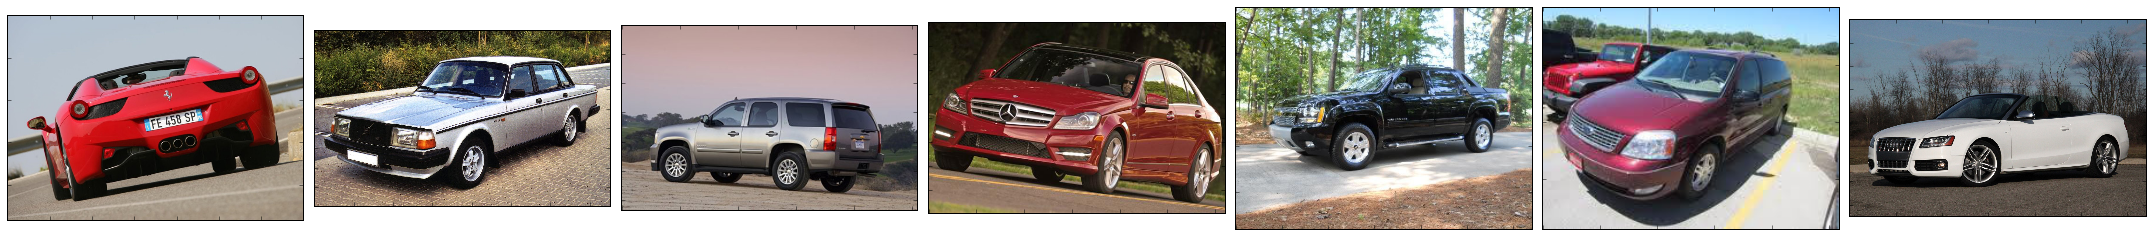

In [2]:
n = 7
folder = '../02456-deep-learning_spes/car_ims'

fig, ax = plt.subplots(1,n,figsize=(30,30))
print("Some random images from the cars dataset")
for i in range(n):
    a = random.choice(os.listdir(folder))
    im = Image.open(folder + '/' + a)
    ax[i].imshow(np.asarray(im))
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())
plt.tight_layout()
plt.show()

In [2]:
# import dictionary with annotations and class names
cars_annos = scipy.io.loadmat('cars_annos.mat')
cars_annos.keys()

dict_keys(['annotations', '__globals__', 'class_names', '__header__', '__version__'])

The annotations provide coordinates for bounding boxes, class labels, and assignment to train/ test

In [3]:
# clean up and convert annotations to dataframe
df_cars = pd.DataFrame(cars_annos['annotations'][0])

In [4]:
for coln in df_cars.columns[1:].tolist():
    df_cars[coln] = [i[0][0] for i in df_cars[coln]]

df_cars['relative_im_path'] = [i[0] for i in df_cars['relative_im_path']]

In [5]:
df_cars.head()

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,car_ims/000001.jpg,112,7,853,717,1,0
1,car_ims/000002.jpg,48,24,441,202,1,0
2,car_ims/000003.jpg,7,4,277,180,1,0
3,car_ims/000004.jpg,33,50,197,150,1,0
4,car_ims/000005.jpg,5,8,83,58,1,0


In [8]:
# create list with the 196 class names (model, make, year)
class_names = list()
for l in cars_annos['class_names'][0]:
    class_names.append(l[0])

# create list with labels for all images
label = list()
for i in range(16185):
    k = cars_annos['annotations'][0][i][5][0][0]
    label.append(class_names[k-1])

Original and cropped version of car_ims/008570.jpg showing the Fisker Karma Sedan 2012


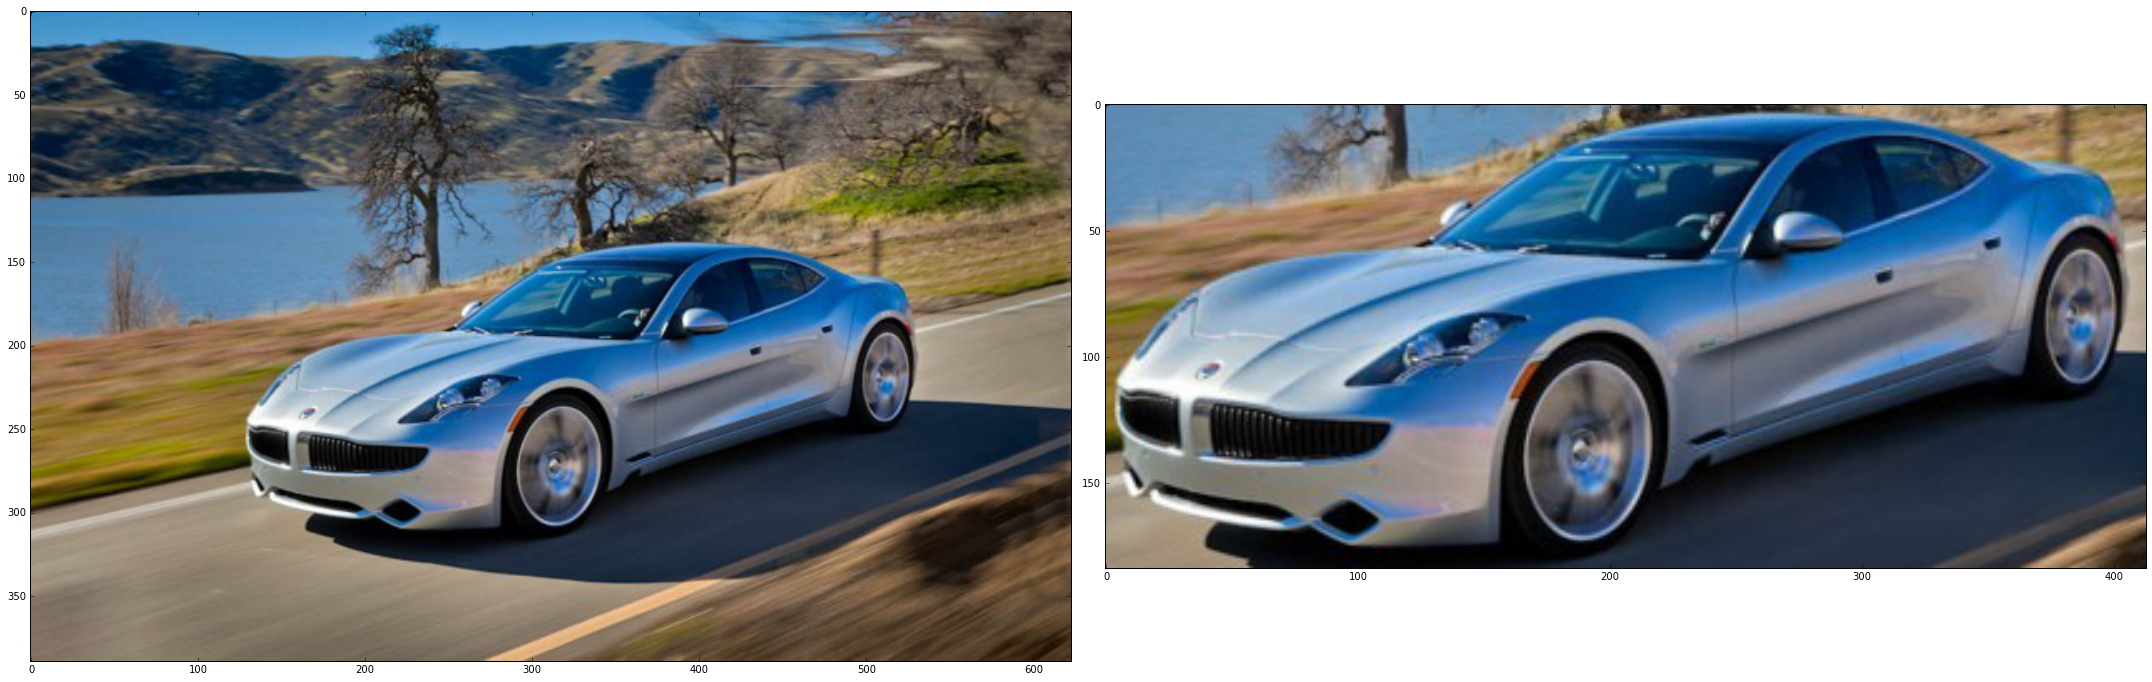

In [9]:
# display a random image (original and cropped with bounding box)
a = random.randint(0, 16184)
image = cars_annos['annotations'][0][a][0][0]
x1 = cars_annos['annotations'][0][a][1][0][0]
y1 = cars_annos['annotations'][0][a][2][0][0]
x2 = cars_annos['annotations'][0][a][3][0][0]
y2 = cars_annos['annotations'][0][a][4][0][0]

print('Original and cropped version of ' + image + ' showing the ' + label[a])
fig, ax = plt.subplots(1,2,figsize=(30,30))
im = Image.open('../02456-deep-learning_spes/' + image)
ax[0].imshow(np.asarray(im))
ax[1].imshow(np.asarray(im.crop((x1, y1, x2, y2))))
plt.tight_layout()
plt.show()

## Structure the data in folders for modelling in keras

In [10]:
# create test folder, then train and validation folders with subfolders for each class

for subfolder_name in class_names:
    os.makedirs(os.path.join('train', subfolder_name))
    os.makedirs(os.path.join('validation', subfolder_name))

In [9]:
# define list with train, test validation groups to be used when storing cropped files below
group = ['train', 'validation']

In [12]:
# crop all images in the data set based on bounding boxes and store in train, validation and test folders
for i in range(16185):
    image = '../02456-deep-learning_spes/' + cars_annos['annotations'][0][i][0][0]
    im_name = df_cars.ix[i, 'relative_im_path'][8:]
    x1 = df_cars.ix[i,'bbox_x1']
    y1 = df_cars.ix[i,'bbox_y1']
    x2 = df_cars.ix[i,'bbox_x2']
    y2 = df_cars.ix[i,'bbox_y2']
    group_idx = df_cars.ix[i, 'test']
    im = Image.open(image)
    im = im.crop((x1, y1, x2, y2))
    im.save('../02456-deep-learning_spes/' + group[group_idx] + '/' + label[i] + '/crop_' + im_name)

In [10]:
# dimensions of our images.  
img_width, img_height = 224, 224  

train_data_dir = '../02456-deep-learning_spes/train'  
validation_data_dir = '../02456-deep-learning_spes/validation'  

In [11]:
# number of epochs to train top model  
epochs = 200

# batch size used by flow_from_directory and predict_generator  
batch_size = 16 

## Training
- Functions below inspired by [The Keras Blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) and [CodeofInterest](http://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html)

In [12]:
# extract and save the bottlenesck features
def bottleneck_features(model, mod_name):
    
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(generator, predict_size_train)
    
    train_save_name = mod_name + '_' + 'bottleneck_features_train.npy'

    np.save(train_save_name, bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(generator, predict_size_validation)
    
    validation_save_name = mod_name + '_' + 'bottleneck_features_validation.npy'

    np.save(validation_save_name, bottleneck_features_validation)

# train the top model on bottleneck features
def train_top_model(train_data, validation_data, top_model_weights_path):
    
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    
    train_datagen_top = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    generator_top = train_datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_labels = generator_top.classes
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("Loss: {}".format(eval_loss))
    
    # summarize history for accuracy and loss
    plt.figure(1, figsize=(18, 6))

    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# predict with the top model only (not used below)
#def classify(model, class_dictionary, top_model_weights_path, image_path):
#
#    num_classes = len(class_dictionary)
#    image = load_img(image_path, target_size=(224, 224))
#    image = img_to_array(image)
#    image = image / 255
#    image = np.expand_dims(image, axis=0)

    # get the bottleneck prediction from the pre-trained model
#    bottleneck_prediction = model.predict(image)

    # build top model
#    model = Sequential()
#    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
#    model.add(Dense(256, activation='relu'))
#    model.add(Dropout(0.5))
#    model.add(Dense(num_classes, activation='sigmoid'))
#    model.load_weights(top_model_weights_path)

    # use bottleneck prediction on the top model to get final classification
#    class_predicted = model.predict_classes(bottleneck_prediction)

#    probabilities = model.predict_proba(bottleneck_prediction)

#    inID = class_predicted[0]

#    inv_map = {v: k for k, v in class_dictionary.items()}
#    label = inv_map[inID]
    
    # return class index only
#    return(label)   

### Modelling strategy: For each of the selected imagenet models
1. Save bottleneck features to be used as training data for top model
2. Train top model (predict and evaluate on test data)
3. Add trained top model to imagenet model and fine tune (predict and evaluate on test data)

In [13]:
# create list of the test files
test_files = ImageDataGenerator().flow_from_directory(validation_data_dir).filenames

Found 618 images belonging to 15 classes.


In [14]:
# create list of true labels for the test files
actual = []
dg = ImageDataGenerator().flow_from_directory(validation_data_dir).filenames
for i in dg:
    actual.append(i[:-16])

Found 618 images belonging to 15 classes.


## VGG16 model

1). Save bottleneck features to be used as training data for top model

In [15]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

bottleneck_features(model = vgg16, mod_name = 'vgg16')

Found 626 images belonging to 15 classes.
Found 618 images belonging to 15 classes.


2). Train top model

Found 626 images belonging to 15 classes.
Found 618 images belonging to 15 classes.
618/618 [==============================] - 0s 120us/step
Accuracy: 79.29%
Loss: 0.6788654801432754


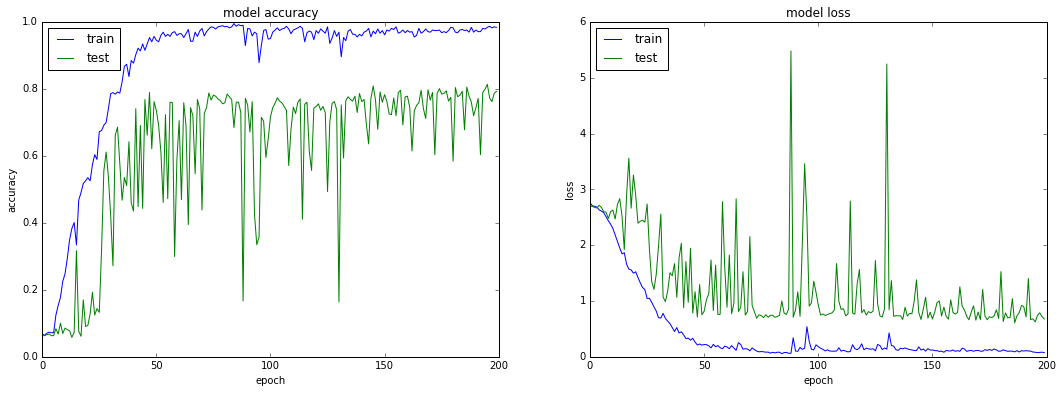

In [16]:
train_data = np.load('vgg16_bottleneck_features_train.npy')
validation_data = np.load('vgg16_bottleneck_features_validation.npy')
top_model_weights_path = 'vgg16_bottleneck_fc_model.h5'

# train the top model with bottleneck features from above
train_top_model(train_data, validation_data, top_model_weights_path)

We could have used this model for classification (see the uncommented code below), but we move directly to the third step

In [3]:
# classify cars in test images
#model = applications.VGG16(include_top=False, weights='imagenet')
#class_dictionary = np.load('class_indices.npy').item()
#top_model_weights_path = 'vgg16_bottleneck_fc_model.h5'

#predict = []
#for file in test_files:
#    image_path = '../02456-deep-learning_spes/validation/' + file
#    predict.append(classify(model, class_dictionary, top_model_weights_path, image_path))

In [2]:
# save the predictions
#with open('vgg16_top_preds.txt', 'wb') as f:
#    pickle.dump(predict, f)

# save the predictions
#with open('vgg16_top_preds.txt', 'rb') as f:
#    vgg_top_preds = pickle.load(f)

# confusion matrix
#m = confusion_matrix(actual, vgg_top_preds)
#print(m)

# plot confusion matrix
#plt.figure(figsize=(8,8))
#plt.matshow(m, fignum=1)
#plt.title('Confusion matrix')
#plt.colorbar()
#plt.ylabel('True label')
#plt.xlabel('Predicted label')
#plt.show()

3). Add trained top model to imagenet model and fine tune (predict and evaluate on test data)

In [17]:
# load VGG16 trained on imagenet without top layer
model = applications.VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3) )
num_classes = 15

# build a classifier model to put on top of the convolutional model
top_model_weights_path = 'vgg16_bottleneck_fc_model.h5'

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation = 'sigmoid'))
top_model.load_weights(top_model_weights_path)

# issue: the model object above is not of type sequential, and it does not have the .add method. 
# We copy layers in model into new_model to fix this
new_model = Sequential()
for l in model.layers:
    new_model.add(l)

# add the new_model on top of the vgg16
new_model.add(top_model)

# freeze the first 16 layers
for layer in new_model.layers[:16]:
    layer.trainable = False

# compile the model with a low learning rate.
new_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [23]:
nb_train_samples = 626
nb_validation_samples = 618
batch_size = 2
epochs = 200

In [24]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [25]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 626 images belonging to 15 classes.
Found 618 images belonging to 15 classes.


In [26]:
# fine-tune the model
history = new_model.fit_generator(
    train_generator,
    steps_per_epoch = int(nb_train_samples//batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps = int(nb_validation_samples//batch_size))

Epoch 1/200
313/313 [==============================] - 12s 40ms/step - loss: 1.9311 - acc: 0.3658 - val_loss: 1.1562 - val_acc: 0.6327
Epoch 2/200
313/313 [==============================] - 12s 38ms/step - loss: 1.4081 - acc: 0.5511 - val_loss: 0.6819 - val_acc: 0.7767
Epoch 3/200
313/313 [==============================] - 12s 39ms/step - loss: 1.0502 - acc: 0.6789 - val_loss: 0.8909 - val_acc: 0.7023
Epoch 4/200
313/313 [==============================] - 12s 38ms/step - loss: 0.9756 - acc: 0.7013 - val_loss: 0.5140 - val_acc: 0.8333
Epoch 5/200
313/313 [==============================] - 12s 39ms/step - loss: 0.8381 - acc: 0.7300 - val_loss: 0.4184 - val_acc: 0.8657
Epoch 6/200
313/313 [==============================] - 12s 39ms/step - loss: 0.6672 - acc: 0.8147 - val_loss: 0.4515 - val_acc: 0.8641
Epoch 7/200
313/313 [==============================] - 12s 38ms/step - loss: 0.6752 - acc: 0.7796 - val_loss: 0.4762 - val_acc: 0.8430
Epoch 8/200
313/313 [==============================] - 

In [27]:
# save the final model for future use
new_model.save('vgg16_tuned.h5')

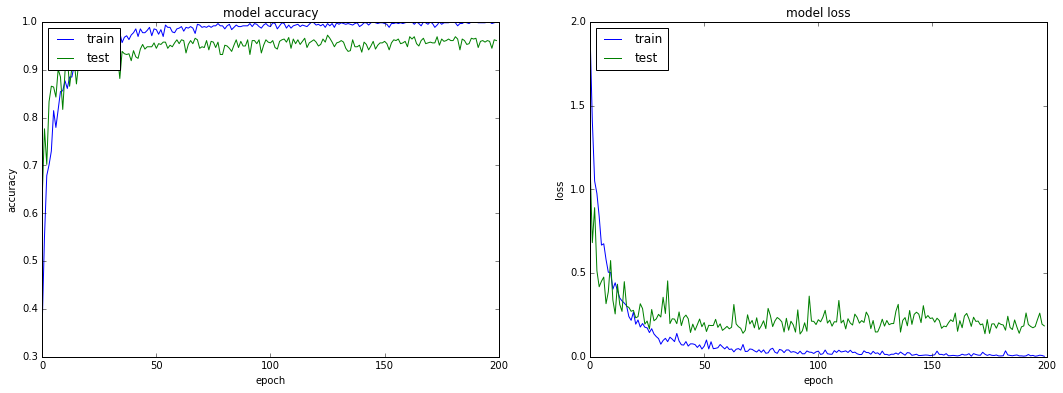

In [28]:
# summarize history for accuracy and loss
plt.figure(1, figsize=(18, 6))

plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
# used the saved model for predicting classes
vgg16_tuned = load_model('vgg16_tuned.h5')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False)

Found 618 images belonging to 15 classes.


[[44  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  5  0  0  1  0  0  1  1  0  0  0  0  0]
 [ 0  1 41  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 43  0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  0 40  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 44  0  0  0  0  0  0  0]
 [ 1  0  3  0  0  0  0  0 37  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 36  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0 47  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0  0 45  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0 41  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 38]]


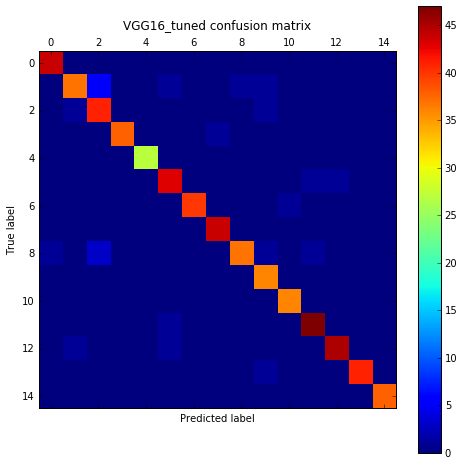

In [30]:
pr = vgg16_tuned.predict_generator(test_generator, steps = 618)

# list with predicted classes
predict = []
for i in range(618):
    predict.append(pr[i].argmax(axis = 0))

# list with actual classes
actual = test_generator.classes

# confusion matrix
m = confusion_matrix(actual, predict)
print(m)

# plot the confusion matrix
plt.figure(figsize=(8,8))
plt.matshow(m, fignum=1)
plt.title('VGG16_tuned confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
# the classes
test_generator.class_indices

{'AM General Hummer SUV 2000': 0,
 'Aston Martin V8 Vantage Convertible 2012': 1,
 'Audi R8 Coupe 2012': 2,
 'Dodge Sprinter Cargo Van 2009': 3,
 'FIAT 500 Abarth 2012': 4,
 'Ford Focus Sedan 2007': 5,
 'GMC Terrain SUV 2012': 6,
 'Jeep Patriot SUV 2012': 7,
 'Lamborghini Aventador Coupe 2012': 8,
 'MINI Cooper Roadster Convertible 2012': 9,
 'Mazda Tribute SUV 2011': 10,
 'Mercedes-Benz 300-Class Convertible 1993': 11,
 'Mitsubishi Lancer Sedan 2012': 12,
 'Nissan Leaf Hatchback 2012': 13,
 'Rolls-Royce Ghost Sedan 2012': 14}

## VGG19 model

1). Save bottleneck features to be used as training data for top model

In [15]:
vgg19 = applications.VGG19(include_top=False, weights='imagenet')

bottleneck_features(model = vgg19, mod_name = 'vgg19')

Found 626 images belonging to 15 classes.
Found 618 images belonging to 15 classes.


2). Train top model (predict and evaluate on test data)

In [17]:
epochs = 55

Found 626 images belonging to 15 classes.
Found 618 images belonging to 15 classes.
618/618 [==============================] - 0s 132us/step
Accuracy: 33.98%
Loss: 1.9550804436013922


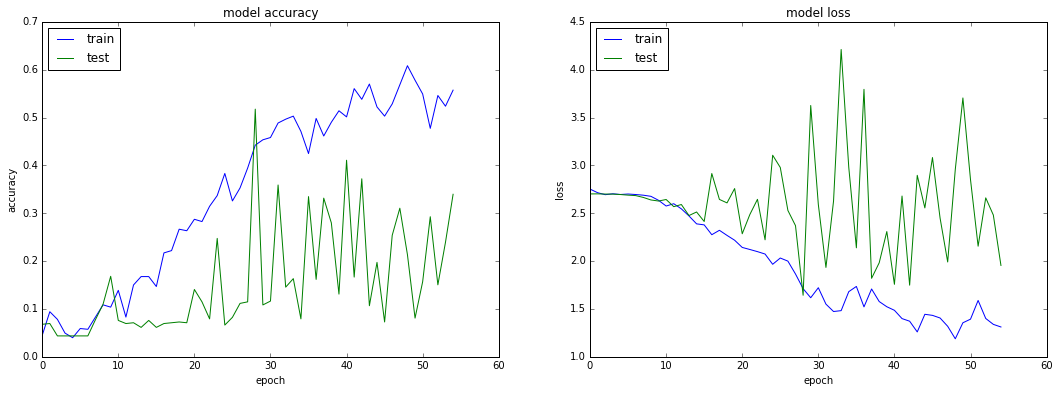

In [20]:
train_data = np.load('vgg19_bottleneck_features_train.npy')
validation_data = np.load('vgg19_bottleneck_features_validation.npy')
top_model_weights_path = 'vgg19_bottleneck_fc_model.h5'

# train the top model with bottleneck features from above
train_top_model(train_data, validation_data, top_model_weights_path)

We could have used this model for classification (see the uncommented code below), but we move directly to the third step

In [4]:
# classify cars in test images
#model = applications.VGG19(include_top=False, weights='imagenet')
#class_dictionary = np.load('class_indices.npy').item()
#top_model_weights_path = 'vgg19_bottleneck_fc_model.h5'

#predict = []
#for file in test_files:
#    image_path = '../02456-deep-learning_spes/validation/' + file
#    predict.append(classify(model, class_dictionary, top_model_weights_path, image_path))

In [5]:
# save the predictions
#with open('vgg19_top_preds.txt', 'wb') as f:
#    pickle.dump(predict, f)

# save the predictions
#with open('vgg19_top_preds.txt', 'rb') as f:
#    vgg_top_preds = pickle.load(f)

# confusion matrix
#m = confusion_matrix(actual, vgg_top_preds)
#print(m)

# plot confusion matrix
#plt.figure(figsize=(8,8))
#plt.matshow(m, fignum=1)
#plt.title('Confusion matrix')
#plt.colorbar()
#plt.ylabel('True label')
#plt.xlabel('Predicted label')
#plt.show()

3). Add trained top model to imagenet model and fine tune (predict and evaluate on test data)

In [25]:
# load VGG19 trained on imagenet without top layer
model = applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))
num_classes =15

# build a classifier model to put on top of the convolutional model
top_model_weights_path = 'vgg19_bottleneck_fc_model.h5'

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation = 'sigmoid'))
top_model.load_weights(top_model_weights_path)

# issue: the model object above is not of type sequential, and it does not have the .add method. 
# We copy layers in model into new_model to fix this
new_model = Sequential()
for l in model.layers:
    new_model.add(l)

# add the model on top of the convolutional base
new_model.add(top_model)

# freeze the first 18 layers
for layer in new_model.layers[:18]:
    layer.trainable = False
    
# compile the model with a low learning rate.
new_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [29]:
nb_train_samples = 626
nb_validation_samples = 618
batch_size = 2
epochs = 200

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)
    
# fine-tune the model
history = new_model.fit_generator(
    train_generator,
    steps_per_epoch = int(nb_train_samples//batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps = int(nb_validation_samples//batch_size))

Found 626 images belonging to 15 classes.
Found 618 images belonging to 15 classes.
Epoch 1/200
313/313 [==============================] - 13s 41ms/step - loss: 2.0092 - acc: 0.3131 - val_loss: 1.4120 - val_acc: 0.6149
Epoch 2/200
313/313 [==============================] - 12s 39ms/step - loss: 1.6694 - acc: 0.4425 - val_loss: 0.9982 - val_acc: 0.7654
Epoch 3/200
313/313 [==============================] - 12s 39ms/step - loss: 1.5019 - acc: 0.5431 - val_loss: 0.9005 - val_acc: 0.7686
Epoch 4/200
313/313 [==============================] - 12s 40ms/step - loss: 1.2375 - acc: 0.6022 - val_loss: 1.0644 - val_acc: 0.6683
Epoch 5/200
313/313 [==============================] - 13s 40ms/step - loss: 1.1578 - acc: 0.6358 - val_loss: 0.6451 - val_acc: 0.8204
Epoch 6/200
313/313 [==============================] - 13s 41ms/step - loss: 1.0294 - acc: 0.7093 - val_loss: 0.5907 - val_acc: 0.8204
Epoch 7/200
313/313 [==============================] - 13s 40ms/step - loss: 0.8893 - acc: 0.7125 - val_lo

In [30]:
# save the final model for future use
new_model.save('vgg19_tuned.h5')

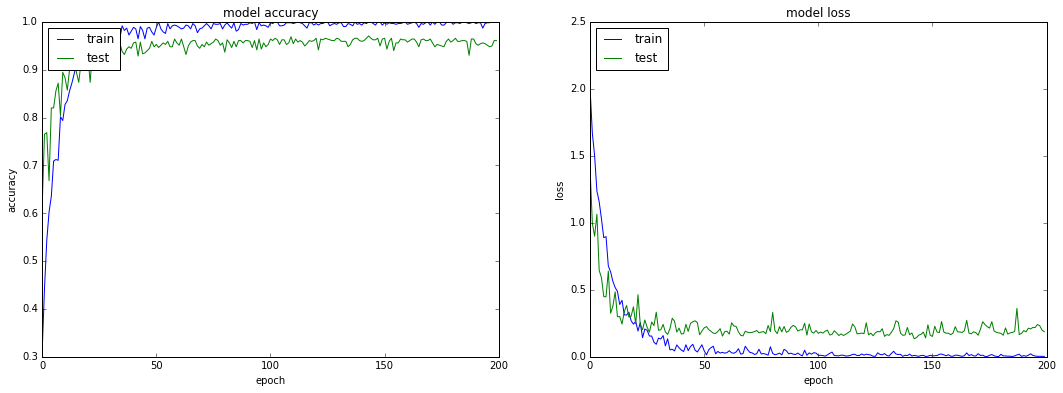

In [31]:
# summarize history for accuracy and loss
plt.figure(1, figsize=(18, 6))

plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
# used the saved model for predicting classes
vgg19_tuned = load_model('vgg19_tuned.h5')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False)

Found 618 images belonging to 15 classes.


[[44  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  4  0  0  1  0  0  1  0  0  0  2  0  0]
 [ 0  1 40  0  0  0  0  0  0  1  0  0  1  0  0]
 [ 0  0  0 39  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 43  0  1  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 40  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 43  0  0  1  0  0  0  0]
 [ 0  0  2  0  0  0  0  0 40  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 36  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0 47  0  0  0]
 [ 0  1  0  0  0  1  1  0  0  0  0  0 44  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0 41  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 37]]


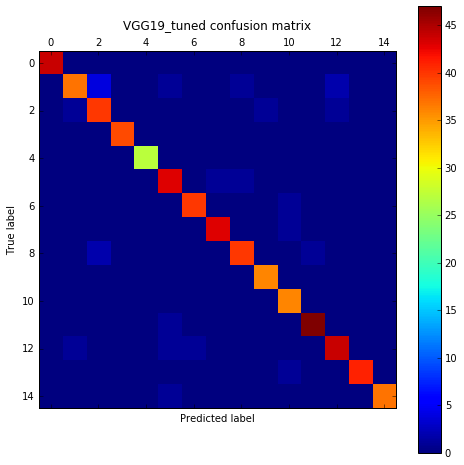

In [34]:
pr = vgg19_tuned.predict_generator(test_generator, steps = 618)

# list with predicted classes
predict = []
for i in range(618):
    predict.append(pr[i].argmax(axis = 0))

# list with actual classes
actual = test_generator.classes

# confusion matrix
m = confusion_matrix(actual, predict)
print(m)

# plot the confusion matrix
plt.figure(figsize=(8,8))
plt.matshow(m, fignum=1)
plt.title('VGG19_tuned confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The baseline model

In [49]:
# baseline model
base = Sequential()
base.add(Conv2D(32, (3, 3), padding='same', input_shape=(224,224, 3)))
base.add(Activation('relu'))
base.add(Conv2D(32,(3, 3)))
base.add(Activation('relu'))
base.add(MaxPooling2D(pool_size=(2, 2)))
base.add(Dropout(0.25))

base.add(Conv2D(64, (3, 3), padding='same'))
base.add(Activation('relu'))
base.add(Conv2D(64, (3,3)))
base.add(Activation('relu'))
base.add(MaxPooling2D(pool_size=(2, 2)))
base.add(Dropout(0.25))

base.add(Flatten())
base.add(Dense(512))
base.add(Activation('relu'))
base.add(Dropout(0.5))
base.add(Dense(num_classes))
base.add(Activation('softmax'))

sgd = SGD(lr = 0.1, decay=1e-6, momentum=0.9, nesterov=True)

In [51]:
base.compile(loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

In [53]:
nb_train_samples = 626
nb_validation_samples = 618
batch_size = 2
epochs = 20

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)#,
    #class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size) #,
    #class_mode='binary')
    
# fine-tune the model
history = base.fit_generator(
    train_generator,
    #samples_per_epoch=nb_train_samples,
    steps_per_epoch = int(nb_train_samples//batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps = int(nb_validation_samples//batch_size))

Found 626 images belonging to 15 classes.
Found 618 images belonging to 15 classes.
Epoch 1/20
313/313 [==============================] - 20s 64ms/step - loss: 14.9683 - acc: 0.0687 - val_loss: 14.9966 - val_acc: 0.0696
Epoch 2/20
313/313 [==============================] - 19s 60ms/step - loss: 14.9594 - acc: 0.0719 - val_loss: 14.9184 - val_acc: 0.0744
Epoch 3/20
313/313 [==============================] - 19s 60ms/step - loss: 14.9594 - acc: 0.0719 - val_loss: 14.8662 - val_acc: 0.0777
Epoch 4/20
313/313 [==============================] - 19s 60ms/step - loss: 14.9594 - acc: 0.0719 - val_loss: 15.0488 - val_acc: 0.0663
Epoch 5/20
313/313 [==============================] - 19s 60ms/step - loss: 14.9594 - acc: 0.0719 - val_loss: 14.9705 - val_acc: 0.0712
Epoch 6/20
313/313 [==============================] - 19s 60ms/step - loss: 14.9594 - acc: 0.0719 - val_loss: 14.9444 - val_acc: 0.0728
Epoch 7/20
313/313 [==============================] - 19s 60ms/step - loss: 14.9594 - acc: 0.0719 - 

In [57]:
# look at the final vgg16_tuned model
vgg16_tuned.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [58]:
# look at the final vgg19_tuned model
vgg19_tuned.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________